# Базовая модель McCall

In [26]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 5)  
import numpy as np
from numba import jit, float64
from numba.experimental import jitclass
import quantecon as qe
from quantecon.distributions import BetaBinomial
import plotly.express as px

### 1) Выгрузка данных(Архангельская область)

Источник: https://ourcountryindata.ru/raspredelenie-zarplat-v-rossii/

In [27]:
data = pd.read_excel('C:/Users/Win 10/Downloads/Распределение зарплат.xlsx')

In [28]:
data = data[data['Регион'] == 'Архангельская область(кроме Ненецкого автономного округа)'].head(10).iloc[[0],:]
data

,Регион,Отрасль,<11280,11280–12140,12140–13000,13000–13850,13850–14700,14700–15850,15850–17000,17000–18050,...,33900–40,40–45 тыс.,45–50 тыс.,50–60 тыс.,60–75 тыс.,75–100 тыс.,100–250 тыс.,250–500 тыс.,500тыс – 1 млн,Свыше 1 млн
25,Архангельская область(кроме Ненецкого автономн...,Всего,0.79,0.19,0.27,0.29,0.35,0.46,0.42,0.54,...,10.87,8.36,6.94,10.14,9.87,8.65,7.39,0.34,0.04,0


In [29]:
data = df1.T.tail(28)
data = data.rename(columns={25: 'p'})
data = data / 100
data = data.reset_index(0).rename(columns={'index': 'w'})
data.head()

,w,p
0,<11280,0.0079
1,11280–12140,0.0019
2,12140–13000,0.0027
3,13000–13850,0.0029
4,13850–14700,0.0035


In [30]:
#cумма вероятностей должга давать единицу
np.sum(data['p'])

1.0

In [31]:
x_low = np.array([0,11280,12140,13000, 13850, 14700, 15850, 17000, 18050, 19200, 20350, 21450, 22560, 
                 23690, 24820, 27100, 29300, 31600, 33900, 40000, 45000, 50000, 60000, 75000, 100000,
                 250000, 500000, 1000000])
x_upper = np.append(x_low[1:],1500000)
data['x_low'] = x_low
data['x_upper'] = x_upper
data['x_middle'] = (data['x_upper'] + data['x_low'])/2
data.head()

,w,p,x_low,x_upper,x_middle
0,<11280,0.0079,0,11280,5640.0
1,11280–12140,0.0019,11280,12140,11710.0
2,12140–13000,0.0027,12140,13000,12570.0
3,13000–13850,0.0029,13000,13850,13425.0
4,13850–14700,0.0035,13850,14700,14275.0


In [32]:
fig = px.line(data, x = 'w', y = 'p', markers=True)
fig.update_layout(title='Вероятность получить ту или иную зп')
fig.show()

### 2) Максимальный размер безработицы

http://www.consultant.ru/law/hotdocs/55695.html/

In [33]:
c = 11280

### 3) Параметр дисконтирования

https://cbr.ru/hd_base/KeyRate/

In [34]:
#ставка цб в 2019 году менялась,берем среднюю

r=(7.75+7.5+7.25+7+6.5+6.25)/6
beta=1/(1+r/100)
beta

0.934215648112106

### 4) CRRA функция полезности

In [35]:
def u(y, σ=2.0):
    if σ != 1:
        return (y**(1 - σ) - 1) / (1 - σ)
    else:
        a = (y**(1 - 1.0001) - 1) / (1 - 1.0001) 
        b = (y**(1 - 0.9999) - 1) / (1 - 0.9999)
        return (a+b)/2

### 5) McCall 1970 с нулевой вероятностью увольнения работника

In [36]:
wages = data['x_middle']
probability = data['p']

In [37]:
class McCallModel:

    def __init__(self,α = 0, c=c, β = beta, w=wages, q=probability, σ = 2.0):
        
        self.α = α
        self.σ = σ
        self.c, self.β= c, β
        self.w, self.q = wages, q
    def update(self, v, d):

        α, β, c, w, q, σ = self.α, self.β, self.c, self.w, self.q, self.σ

        v_new = np.empty_like(v)

        for i in range(len(w)):
            v_new[i] = u(w[i],σ) + β * ((1 - α) * v[i] + α * d)

        d_new = np.sum(np.maximum(v, u(c,σ) + β * d) * q)

        return v_new, d_new


In [38]:
def solve_model(mcm, tol=1e-5, max_iter=2000, σ = 2.0):

    v = np.ones_like(mcm.w)    
    d = 1                      
    i = 0
    error = tol + 1

    while error > tol and i < max_iter:
        v_new, d_new = mcm.update(v, d)
        error_1 = np.max(np.abs(v_new - v))
        error_2 = np.abs(d_new - d)
        error = max(error_1, error_2)
        v = v_new
        d = d_new
        i += 1

    return v, d

### 6) Резервная заработная плата

In [39]:
def compute_reservation_wage(mcm, σ = 2):
    
    v, d = solve_model(mcm)
    h = u(mcm.c,σ) + mcm.β * d

    w_bar = np.inf
    for i, wage in enumerate(mcm.w):
        if v[i] > h:
            w_bar = wage
            break

    return w_bar

In [40]:
mcm = McCallModel(σ = 2, β = beta)
compute_reservation_wage(mcm)

42500.0

Объяснение алгоритма: 

v - общая стоимость жизни, который вступает в текущий период работы с существующей заработной платой

h - общая стоимость жизни, который в текущий период становится безработным и получает предложение о заработной плате w.

d - ожидаемое значение безработицы

1) определяются первые  v и d(как 1) 

2) мы рассчитываем новые  

d_new = np.sum(np.maximum(v, u(c,σ) + β * d) * q)

v_new[i] = u(w[i],σ) + β * ((1 - α) * v[i] + α * d)

3) Теперь мы повторяем до тех пор, пока последовательные реализации не окажутся ближе друг к другу, чем заданный уровень ошибки

Возвращаем текущую итерацию в качестве приблизительного решения.

### 7) Сontourplot для резервной зарплаты в осях параметр дисконтирования и размер пособия

In [41]:
grid_size = 15
R = np.empty((grid_size, grid_size))

c_vals = np.linspace(4000, 18000, grid_size)
β_vals = np.linspace(0.8, 0.99, grid_size)

for i, c in enumerate(c_vals):
    for j, β in enumerate(β_vals):
        mcm = McCallModel(c=c, β = β)
        R[i, j] = compute_reservation_wage(mcm)

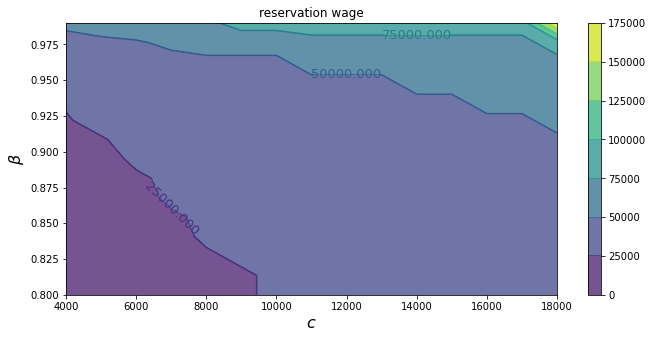

In [42]:
fig, ax = plt.subplots()

cs1 = ax.contourf(c_vals, β_vals, R.T, alpha=0.75)
ctr1 = ax.contour(c_vals, β_vals, R.T)

plt.clabel(ctr1, inline=1, fontsize=13)
plt.colorbar(cs1, ax=ax)


ax.set_title("reservation wage")
ax.set_xlabel("$c$", fontsize=16)
ax.set_ylabel("$β$", fontsize=16)

ax.ticklabel_format(useOffset=False)

plt.show()

### 8) Трехмерный график для резервной зарплаты от параметра дисконтирования и размера пособия

In [43]:
X = c_vals
Y = β_vals
X,Y = np.meshgrid(X,Y)

In [44]:
plot_3d = pd.DataFrame({'c':X.reshape(-1)})

In [45]:
plot_3d['β'] = Y.reshape(-1)
plot_3d['w'] = R.reshape(-1)
plot_3d

,c,β,w
0,4000.0,0.80,14275.0
1,5000.0,0.80,15275.0
2,6000.0,0.80,15275.0
3,7000.0,0.80,16425.0
4,8000.0,0.80,17525.0
...,...,...,...
220,14000.0,0.99,55000.0
221,15000.0,0.99,55000.0
222,16000.0,0.99,67500.0
223,17000.0,0.99,87500.0


In [46]:
fig = px.scatter_3d(plot_3d, x='c', y="β", z="w")
fig.show()

Интерпретация:

Размер резервной заработной платы положительно зависит как от параметра дисконтирования, так и от размера пособия, но второе влияет намного больше

Каким бы важным ни было будущее(при высоком параметре дисконтирования) маленькое пособие сделает резервную зарплату маленькой(и наоборот)

### 9) Графики зависимости резервной зарплаты от дисконт-фактора, размера пособия, вероятности увольнения, и параметра 𝜎

Мы принимаем решение о предложенной зп, когда 

$w > \bar w$ , где $\bar w$ - резервная зп

$v(\bar w)$ =$u(c)$ + $\beta$ * $d$


Параметр дисконтирования отражает насколько важно получить зарплату сейчас => 
 чем выше этот параметр,тем выше ожидаемая ценность отказа



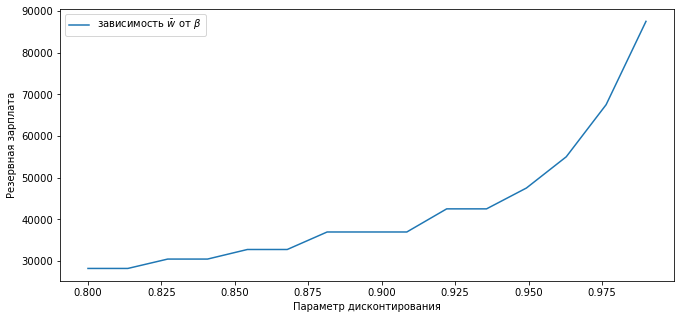

In [47]:
fig, ax = plt.subplots()

mcm = McCallModel()
w_bar_vals = np.empty_like(β_vals)

for i, β in enumerate(β_vals):
    mcm.β = β
    w_bar = compute_reservation_wage(mcm)
    w_bar_vals[i] = w_bar

ax.set(xlabel='Параметр дисконтирования', ylabel='Резервная зарплата')
ax.plot(β_vals, w_bar_vals, label=r'зависимость $\bar w$ от $\beta$')
ax.legend()
print('')
print('Параметр дисконтирования отражает насколько важно получить зарплату сейчас => \n чем выше этот параметр,тем выше ожидаемая ценность отказа')
print('')
plt.show()



Ожидаемая ценность отказа также будет зависеть положительно и от размера пособия, который предлагают



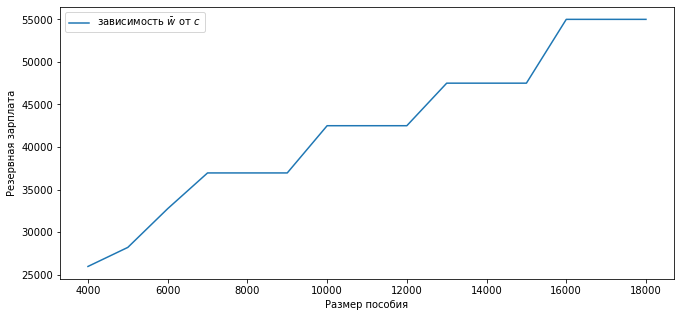

In [48]:
fig, ax = plt.subplots()

mcm = McCallModel(β = beta)
w_bar_vals = np.empty_like(c_vals)

for i, c in enumerate(c_vals):
    mcm.c = c
    w_bar = compute_reservation_wage(mcm)
    w_bar_vals[i] = w_bar

ax.set(xlabel='Размер пособия',
       ylabel='Резервная зарплата')
ax.plot(c_vals, w_bar_vals, label=r'зависимость $\bar w$ от $с$')
ax.legend()

print('')
print('Ожидаемая ценность отказа также будет зависеть положительно и от размера пособия, который предлагают')
print('')
plt.show()

plt.show()


С более высокой вероятностью увольнения падает ценность высокой зарплаты



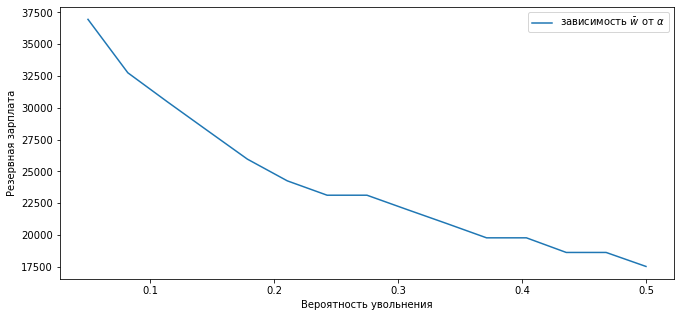

In [49]:
fig, ax = plt.subplots()

mcm = McCallModel(β = beta)
alpha_vals = np.linspace(0.05, 0.5, grid_size)
w_bar_vals = np.empty_like(alpha_vals)

for i, α in enumerate(alpha_vals):
    mcm.α = α
    w_bar = compute_reservation_wage(mcm)
    w_bar_vals[i] = w_bar

ax.set(xlabel='Вероятность увольнения', ylabel='Резервная зарплата')
ax.plot(alpha_vals, w_bar_vals, label=r'зависимость $\bar w$ от $\alpha$')
ax.legend()

print('')
print('С более высокой вероятностью увольнения падает ценность высокой зарплаты')
print('')

plt.show()


Более высокие зарплаты в будущем становятся менее привлекательными при возрастании сигмы
*возрастание параметра напрямую означает снижение функции полезности



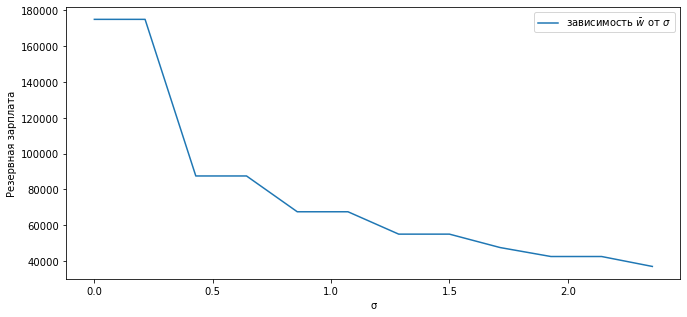

In [50]:
fig, ax = plt.subplots()


σ_vals = np.linspace(0, 3, 15)
w_bar_vals = np.empty_like(σ_vals)

for i, j in enumerate(σ_vals):
    mcm = McCallModel(σ = j, β = beta)
    w_bar = compute_reservation_wage(mcm,σ = j)
    w_bar_vals[i] = w_bar

ax.set(xlabel='σ', ylabel='Резервная зарплата')
ax.plot(σ_vals, w_bar_vals, label=r'зависимость $\bar w$ от $σ$')
ax.legend()

print('')
print('Более высокие зарплаты в будущем становятся менее привлекательными при возрастании сигмы')
print('*возрастание параметра напрямую означает снижение функции полезности')
print('')

plt.show()